# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 350

---

## Import data

This code is provided for you. Some columns with network and score-related data are dropped.

The remaining columns will be `#AUTHID`, `STATUS`, `cEXT`, `cNEU`, `cAGR`, `cCON`, `cOPN`, and `DATE`:

| Variable name | Description                                                                      |
|---------------|----------------------------------------------------------------------------------|
| `#AUTHID`     | Author ID code, unique per user                                                  |
| `STATUS`      | Text of a Facebook status                                                        |
| `cEXT`        | Author extroversion category, `y` for above median and `n` for below median      |
| `cNEU`        | Author neuroticism category, `y` for above median and `n` for below median       |
| `cAGR`        | Author agreeableness category, `y` for above median and `n` for below median     |
| `cCON`        | Author conscientiousness category, `y` for above median and `n` for below median |
| `cOPN`        | Author openness category, `y` for above median and `n` for below median          |
| `DATE`        | Time stamp of original Facebook status                                           |


In [2]:
df = pd.read_csv('data/mypersonality.csv')
# df = pd.read_csv('data/mypersonality_noprofanity.csv') # comment out above & uncomment this to use mypersonality_noprofanity.csv

dropcols = [
    # these are network-related columns:
    'NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY',
    'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY',
    # these are score-related columns;
    # we will use the catgories instead:
    'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN'
]

df.drop(columns=dropcols, inplace=True)
df.head(3)

,#AUTHID,STATUS,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",n,y,n,n,y,06/15/09 01:15 PM


## Data cleaning

It's often more convenient to work with integers than strings. Convert the personality columns to 0 and 1, with 0 meaning 'below the median' and 1 meaning 'above the median.'

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.head()

,#authid,status,cext,cneu,cagr,ccon,copn,date
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",n,y,n,n,y,06/15/09 01:15 PM
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,n,y,n,n,y,06/22/09 04:48 AM
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,n,y,n,n,y,07/20/09 02:31 AM


In [5]:
#replace each column with 1 for y, 0 for n
df['cext'] = df['cext'].replace('y',1)
df['cext'] = df['cext'].replace('n',0)

In [6]:
df['cneu'] = df['cneu'].replace('y',1)
df['cneu'] = df['cneu'].replace('n',0)

In [7]:
df['cagr'] = df['cagr'].replace('y',1)
df['cagr'] = df['cagr'].replace('n',0)

In [8]:
df['ccon'] = df['ccon'].replace('y',1)
df['ccon'] = df['ccon'].replace('n',0)

In [9]:
df['copn'] = df['copn'].replace('y',1)
df['copn'] = df['copn'].replace('n',0)

In [10]:
df.head()

,#authid,status,cext,cneu,cagr,ccon,copn,date
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,0,1,0,0,1,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,0,1,0,0,1,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",0,1,0,0,1,06/15/09 01:15 PM
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,0,1,0,0,1,06/22/09 04:48 AM
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,0,1,0,0,1,07/20/09 02:31 AM


-----

## A first look at the dataset

In this section, check:

- How many observations are there in the dataset?

    -- 9916
- How many unique `#AUTHID` codes are there?

    -- 250
- How many `y` and `n` values are in each of the personality category columns?

    -- cEXT: no - 5707, yes - 4209
    
    -- cNEU: no - 6199, yes - 3717
    
    -- cAGR: no - 5267, yes - 4649
    
    -- cCON: no - 5360, yes - 4556
    
    -- cOPN: no - 7369, yes - 2547

In [11]:
df.count()

#authid    9916
status     9916
cext       9916
cneu       9916
cagr       9916
ccon       9916
copn       9916
date       9916
dtype: int64

In [12]:
len(df['#authid'].unique())

250

In [13]:
# cEXT	cNEU	cAGR	cCON	cOPN

df['cext'].value_counts(), df['cneu'].value_counts() ,df['cagr'].value_counts(), df['ccon'].value_counts(),df['copn'].value_counts()

(0    5707
 1    4209
 Name: cext, dtype: int64,
 0    6199
 1    3717
 Name: cneu, dtype: int64,
 1    5267
 0    4649
 Name: cagr, dtype: int64,
 0    5360
 1    4556
 Name: ccon, dtype: int64,
 1    7369
 0    2547
 Name: copn, dtype: int64)


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status. Some personality types might be more long-winded than others!

### Create a new column called `status_char_length` that contains the character length of each status

> Note: You can do this in one line with `map`.

In [14]:
#https://stackoverflow.com/questions/56968917/count-of-characters-in-a-row-as-a-new-column
df['status_char_length'] = df['status'].str.len()

In [179]:
def myfunc(n):
    return len(n)

df['status_char_length'] = map(myfunc, df['status'])

In [15]:
df.head()

,#authid,status,cext,cneu,cagr,ccon,copn,date,status_char_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,0,1,0,0,1,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,0,1,0,0,1,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",0,1,0,0,1,06/15/09 01:15 PM,121
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,0,1,0,0,1,06/22/09 04:48 AM,42
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,0,1,0,0,1,07/20/09 02:31 AM,11


### Create a new column called `status_word_count` that contains the number of words in each status

> Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [135]:
# [len(df['status'].split(' '))for each in df['status']]

In [29]:
#https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/
import re
df['status_word_count'] = [len(re.findall(r'\w+',each)) for each in df['status']]

In [30]:
df.head()

,#authid,status,cext,cneu,cagr,ccon,copn,date,status_char_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,0,1,0,0,1,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,0,1,0,0,1,07/02/09 08:41 AM,63,16
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",0,1,0,0,1,06/15/09 01:15 PM,121,27
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,0,1,0,0,1,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,0,1,0,0,1,07/20/09 02:31 AM,11,3


---

## Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

### Show the five longest and five shortest statuses based off of `status_word_count`

In [27]:
df['status_word_count'].sort_values(ascending = False).head(5)

7976    95
496     94
6989    92
5208    88
8026    86
Name: status_word_count, dtype: int64

In [28]:
df['status_word_count'].sort_values(ascending = True).head(5)

9621    0
3280    0
9566    0
4392    0
427     0
Name: status_word_count, dtype: int64

---

## Investigating distribution of post lengths

We've now seen some of the shortest and longest posts in the dataset. But how common are short posts, and how common are long posts? 

Use visuals to show the distributions of post lengths.

> Note: There are multiple different types of visualizations you could use for this, and you could investigate this by looking at `status_word_count`, `status_char_length`, or both.

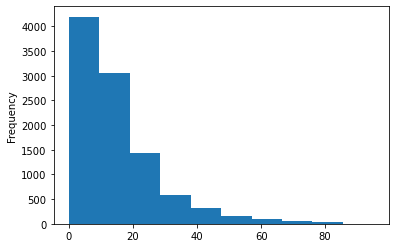

In [36]:
df['status_word_count'].plot(kind='hist');

<AxesSubplot:ylabel='Frequency'>

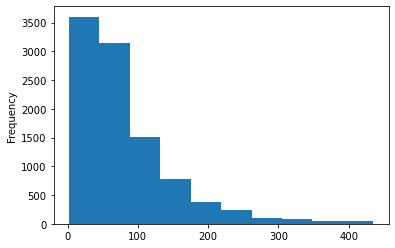

In [37]:
df['status_char_length'].plot(kind='hist')

---

## Exploring personality categories and individual users

Because we have many posts per user for most users, doing EDA on the personality columns might be misleading. If we have 2,000 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `1` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there? Do we have the same number of posts per user, or do we have some more posts by some users than others?

In [59]:
len(df['#authid'].unique())

250

In [46]:
#counts
df.groupby(by='#authid').count().sort_values(by= 'status', ascending=False)

,status,cext,cneu,cagr,ccon,copn,date,status_char_length,status_word_count
#authid,,,,,,,,,
e6cdef6f475cce3023c5b715f8c9f110,223,223,223,223,223,223,223,223,223
6f2bebc01062eb8334dccba3e048fdb5,219,219,219,219,219,219,219,219,219
527ed53d2ba3a3bc417b8402d5b2f556,194,194,194,194,194,194,194,194,194
d7e500ad854a1b6ced39e53a525b8a6d,184,184,184,184,184,184,184,184,184
0737e4e4980f56c9fb1cb5743001c917,172,172,172,172,172,172,172,172,172
...,...,...,...,...,...,...,...,...,...
ac8bf16a381d07c01b11651994ecb746,1,1,1,1,1,1,1,1,1
5532642937eb3497a43e15dbb23a9d2d,1,1,1,1,1,1,1,1,1
22d1f7b24168528163c515b1c96a879c,1,1,1,1,1,1,1,1,1


In [49]:
#Averages
df.groupby(by='#authid').mean()


,cext,cneu,cagr,ccon,copn,status_char_length,status_word_count
#authid,,,,,,,
00419a4c96b32cd63b2c7196da761274,0.0,1.0,0.0,1.0,0.0,15.000000,3.000000
02c37028a782cfda660c7243e45244bb,0.0,1.0,0.0,0.0,0.0,57.000000,6.500000
03133a828cd0cf52e3752813ce5d818f,1.0,1.0,0.0,1.0,0.0,133.800000,27.400000
03e6c4eca4269c183fa0e1780f73faba,0.0,1.0,1.0,1.0,1.0,117.750000,20.750000
06b055f8e2bca96496514891057913c3,0.0,0.0,0.0,1.0,0.0,116.666667,21.333333
...,...,...,...,...,...,...,...
f83aa7290cf3ae8ed75d6aee5ebbb559,0.0,0.0,1.0,0.0,0.0,22.000000,4.000000
fbe5aa478508d1dc931427ade5d9e1b4,0.0,0.0,0.0,1.0,1.0,83.333333,15.666667
fc1c9fb6c64740edcbbf8cfe9dde8b02,0.0,0.0,1.0,0.0,1.0,87.866667,16.700000


---

### Create a new dataframe called `unique_users` that only contains the `#AUTHID` and personality category columns

If you do this correctly, it should have 250 rows and 6 columns.*

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

> Note: *If using the `noprofanity` dataset, this number may be different.

In [64]:
unique_users = df[['#authid','cext','cneu','cagr','ccon','copn']]

In [67]:
unique_users=unique_users.drop_duplicates(subset = '#authid')

In [74]:
unique_users.reset_index(inplace=True)

In [80]:
unique_users.drop(columns='index', inplace=True)

In [81]:
unique_users

,#authid,cext,cneu,cagr,ccon,copn
0,b7b7764cfa1c523e4e93ab2a79a946c4,0,1,0,0,1
1,318bf822d4f2bd3920367560218619c0,1,1,0,1,0
2,ecbddbfe00e0f83cfdb802a7186061c7,1,0,1,0,1
3,db39f7b2aad360b1033ec1f8fcd57f9c,1,1,0,1,1
4,4d035bd3fd8d9595d15cea9e388964be,1,1,0,0,1
...,...,...,...,...,...,...
245,a764ca41dca158d7a191505dcc8ce47f,1,0,1,1,0
246,deb899e426c1a5c66c24eeb0d7df6257,0,0,1,0,1
247,ea28a927cb6663480ea33ca917c3c8ba,1,1,1,1,1
248,5532642937eb3497a43e15dbb23a9d2d,0,1,0,0,1



| Variable name | Description                                                                      |
|---------------|----------------------------------------------------------------------------------|
| `#AUTHID`     | Author ID code, unique per user                                                  |
| `STATUS`      | Text of a Facebook status                                                        |
| `cEXT`        | Author extroversion category, `1` for above median and `0` for below median      |
| `cNEU`        | Author neuroticism category, `1` for above median and `0` for below median       |
| `cAGR`        | Author agreeableness category, `1` for above median and `0` for below median     |
| `cCON`        | Author conscientiousness category, `1` for above median and `0` for below median |
| `cOPN`        | Author openness category, `1` for above median and `0` for below median          |
| `DATE`        | Time stamp of original Facebook status                                           |


### Using `unique_users`, investigate personality

For this section, perform EDA on just the unique users. Create 2-3 tables or visuals to investigate.

Here are some prompts to get you started:

- What proportion of above-median openness users also exhibit above-median extroversion vs. below-median extroversion? What about other pairs of personality traits?

   **-- 70% of users exhibit above-median openness.**
    
    **-- 61% of users exhibit above-median extroversion**
    
   **-- 28% of users exhibit both above median-opennes and above-median extroversion.**
    
- Do any two personality traits appear to be correlated?
    
    **-- extroversion + conscientiousness are correlated at 18%**
    
    **-- agreeableness + openness are correlated at 20%**
    
    
- Are about equal numbers of users above median conscientiousness and below median conscientiousness, or is there an imbalanced split? What about the other personality traits?

    **-- conscientiousness: it is almost an even split, with 52% above median and 48% below**
    

- Are any users below-median across all five personality traits? How many?

    **-- 3**
    
- Are any users above-median all five personality traits? How many?
    
    **-- 4**
    
For each dataframe or plot you end up with, remember to provide interpretation in markdown as well.

In [213]:
len(unique_users.loc[(unique_users['cext']==1) & (unique_users['copn']==1)])

72

In [130]:
unique_users['sum_personality']=unique_users.sum(axis=1)

In [134]:
unique_users.sort_values(by = 'sum_personality', ascending=False)

,#authid,cext,cneu,cagr,ccon,copn,sum_personality
247,ea28a927cb6663480ea33ca917c3c8ba,1,1,1,1,1,5
242,ea890531d3e0547166efde52d843099e,1,1,1,1,1,5
60,448084546d4ae45e47c3a83f338ade56,1,1,1,1,1,5
9,9a8cf1dcb2de1a8f70c4745a636bbb96,1,1,1,1,1,5
125,c87247ddb57f8d8ff43086ac88e69120,1,0,1,1,1,4
...,...,...,...,...,...,...,...
96,1886cffe45f0ee0240eda42e44a01e07,1,0,0,0,0,1
142,d7e500ad854a1b6ced39e53a525b8a6d,0,1,0,0,0,1
155,e0576e496b3bc5bd1046315ddb72646a,0,0,0,0,0,0
78,1bd281623fa6ad208caa394dcad75c7d,0,0,0,0,0,0


In [154]:
#unique users with 0, 5 personality traits
len(unique_users[unique_users['sum_personality']==0]),len(unique_users[unique_users['sum_personality']==5])

(3, 4)

In [116]:
unique_users.corr()

,cext,cneu,cagr,ccon,copn
cext,1.000000,-0.269335,0.091429,0.182399,0.079561
cneu,-0.269335,1.000000,-0.312656,-0.237050,-0.030387
cagr,0.091429,-0.312656,1.000000,0.085410,0.204943
ccon,0.182399,-0.237050,0.085410,1.000000,0.008419
copn,0.079561,-0.030387,0.204943,0.008419,1.000000


<AxesSubplot:>

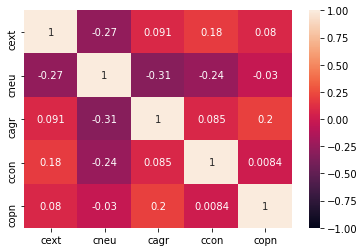

In [120]:
# plt.figure(figsize=(8,12))
sns.heatmap(data=unique_users.corr(),vmin=-1, vmax=1, annot=True)

In [222]:
unique_users['cext'].value_counts(normalize=True), unique_users['cneu'].value_counts(normalize=True), unique_users['cagr'].value_counts(normalize=True), unique_users['ccon'].value_counts(normalize=True), unique_users['ccon'].value_counts(normalize=True), unique_users['copn'].value_counts(normalize=True), 

(0    0.616
 1    0.384
 Name: cext, dtype: float64,
 0    0.604
 1    0.396
 Name: cneu, dtype: float64,
 1    0.536
 0    0.464
 Name: cagr, dtype: float64,
 1    0.52
 0    0.48
 Name: ccon, dtype: float64,
 1    0.52
 0    0.48
 Name: ccon, dtype: float64,
 1    0.704
 0    0.296
 Name: copn, dtype: float64)

## Plots vs. Tables

(Short answer.) Explain when you might present a visualization versus when you might present a table of summary statistics. You can provide your answer using sentences or bullet points.

 -- I would use a visualization for statitistics like correlation or distribution. The concepts are more easily digestible when visualized.
 
 -- Similarly, I would use a  visualization when looking at specific relationships between the variables.
 
 -- Summary statistics are a good way to recap the data or give a snapshot of how the data looks at a glance. They are common enough that anyone looking to understand the data can read them. 

---

## Exploring status length and word count based on personality

### Using `groupby()`, find the mean status length and status word count for posts by users in the above-median and below-median categories of each of the personality traits

> Note: Using `groupby()` five separate times is the easiest way to do this.

### Distribution of post length for above- and below-median personality traits

Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Visualize the distribution of status word counts of posts for users who are both above-median and below-median on that trait.

> Note: This can be done several ways -- using seaborn or matplotlib, and as overlapping histograms or as side-by-side or stacked histograms.

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [295]:
# 5.04-lesson-nlp-ii/starter-code-in-class.ipynb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvec = CountVectorizer(stop_words='english')

In [372]:
X=df['status']


In [373]:
cvec.fit(X)

CountVectorizer(stop_words='english')

In [374]:
Z = cvec.transform(X)

### Show the 15 most common words

In [375]:
pd.DataFrame(Z.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,15173,15174,15175,15176,15177,15178,15179,15180,15181,15182
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [376]:
Zdf = pd.DataFrame(Z.todense(), columns=cvec.get_feature_names())


In [377]:
#15 most common words
Zdf.sum().sort_values(ascending=False).head(15)


propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

In [378]:
top15=Zdf.sum().sort_values(ascending=False).head(15)

In [379]:
top15df = pd.DataFrame(data=top15, columns= ['count'])

In [380]:
top15df.reset_index(inplace=True)

In [381]:
top15df.rename(columns ={'index':'word',
                         'count':'count'}, inplace=True)

In [382]:
top15df

,word,count
0,propname,1309
1,just,717
2,day,534
3,like,506
4,time,424
5,going,414
6,today,402
7,new,386
8,work,369
9,good,354


### Show the 15 frequency of the most common words as a bar chart

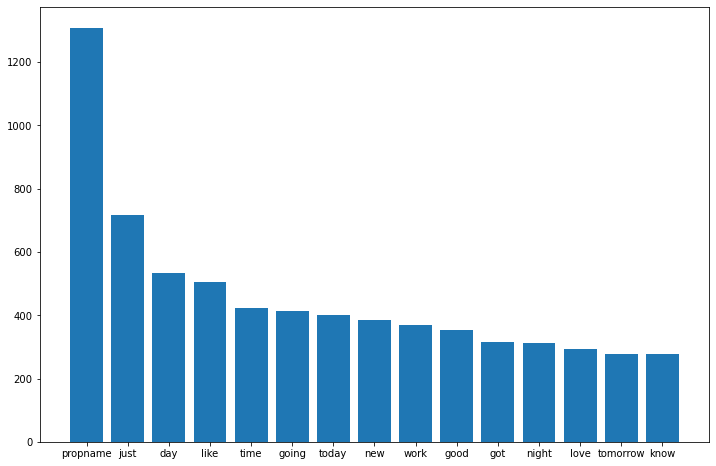

In [383]:
plt.figure(figsize = (12,8))
plt.bar(data=top15df, x='word', height = 'count');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show 10 statuses in the dataset that contain `propname`:

In [395]:
#https://stackoverflow.com/questions/42931920/pandas-countvectorizer-how-to-filter-rows-quickly
#this was very difficult so I had to use the same variable names to make it work

ft = cvec.get_feature_names()
m =cvec.transform(df['status'])
m.toarray()

idx = m[:, ft.index('propname')] == 1

df[idx.toarray()]

,#authid,status,cext,cneu,cagr,ccon,copn,date,status_char_length,status_word_count
6,b7b7764cfa1c523e4e93ab2a79a946c4,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.",0,1,0,0,1,06/27/09 05:41 AM,95,15
18,b7b7764cfa1c523e4e93ab2a79a946c4,"is tired. *PROPNAME*, let me go to sleep pl0x.",0,1,0,0,1,07/11/09 05:44 AM,46,9
69,b7b7764cfa1c523e4e93ab2a79a946c4,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.,0,1,0,0,1,11/24/09 05:07 AM,137,26
101,b7b7764cfa1c523e4e93ab2a79a946c4,has a serious crush on *PROPNAME*. <3,0,1,0,0,1,01/25/10 02:57 AM,37,7
104,318bf822d4f2bd3920367560218619c0,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles,1,1,0,1,0,06/23/09 05:41 AM,98,12
...,...,...,...,...,...,...,...,...,...,...
9799,c5898ecc4c7407e6f07cc3485073d3a6,My 2005 *PROPNAME* has a ridiculously sharp throttle response. I wonder if it has anything to do with the unintended acceleration problems...,0,0,1,0,1,02/02/10 02:43 AM,142,22
9817,da8787edc39ba38d6bc9f0d10e28aa0f,Today was the *PROPNAME*'s B day :( R.I.P.,0,0,1,0,1,02/10/10 01:46 AM,42,10
9842,f6e7722b811d00a7a40de2ecfab636e6,"wow. I was searching my name in facebook, and suprisingly enough, i'm not the only *PROPNAME* in the world (obviously), and they all seem to resemble me in some way.....try it! facebook search your name and check out the crazy resemblances (if any)",0,0,1,0,1,11/27/09 06:05 PM,248,45
9864,6c651f6e7d9104dac0ab60549f89fbb7,*PROPNAME* make things work,0,1,1,0,1,11/14/09 02:01 AM,27,4


#### Provide a short explanation of what you believe `propname` to be:

> Note: The attached PDF also contains an explanation.

I believe propname is tagging another person in the status, or someone else's name that was removed from the data set for privacy.  

-----

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality columns from the original dataframe.

### Create a new dataframe with the vectorized text _and_ the personality category columns

> Note: One way to do this is by using [`pd.concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html).

### Show the 25 most common words for statuses from high-cAGR users

### Show the 25 most common words for statuses from low-cAGR users

-----

### (BONUS) Most common bigrams:

This is a bonus section and not required.

Find the 10 most common bigrams in the dataset.

> Note: The easiest way to do this involves instantiating a new `CountVectorizer`.

### (BONUS) Most common trigrams:

This is a bonus section and not required.

Find the 10 most common trigrams in the dataset.

> Note: The easiest way to do this involves instantiating a new `CountVectorizer`.

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:

- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate.

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.